In [85]:
%pip install torch torchvision matplotlib opencv-python timm scipy

Note: you may need to restart the kernel to use updated packages.


In [86]:
import torch
import urllib
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load MiDaS model from PyTorch Hub
model_type = "DPT_Large"  # Other options: "DPT_Hybrid", "MiDaS_small"
midas = torch.hub.load("intel-isl/MiDaS", model_type)
midas.eval()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
midas.to(device)

# Load transforms
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.dpt_transform if "DPT" in model_type else midas_transforms.small_transform

Using cache found in /Users/anarmammadov/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /Users/anarmammadov/.cache/torch/hub/intel-isl_MiDaS_master


In [87]:
img_name = 109934

libpng warning: iCCP: known incorrect sRGB profile


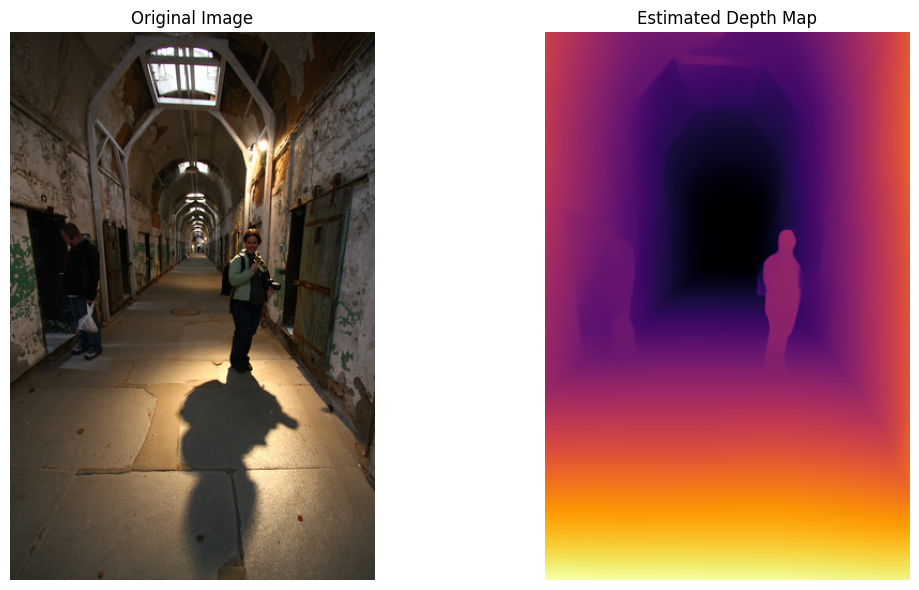

In [88]:
img_path = f"before/{img_name}.png"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Preprocess
input_batch = transform(img).to(device)

# Run inference
with torch.no_grad():
    prediction = midas(input_batch)

# Resize prediction to original size
depth_map = torch.nn.functional.interpolate(
    prediction.unsqueeze(1),
    size=img.shape[:2],
    mode="bicubic",
    align_corners=False
).squeeze().cpu().numpy()

# Normalize for visualization
depth_map_vis = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())

# Show image and depth map
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(img)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Estimated Depth Map")
plt.imshow(depth_map_vis, cmap="inferno")
plt.axis("off")
plt.tight_layout()
plt.show()

libpng warning: iCCP: known incorrect sRGB profile


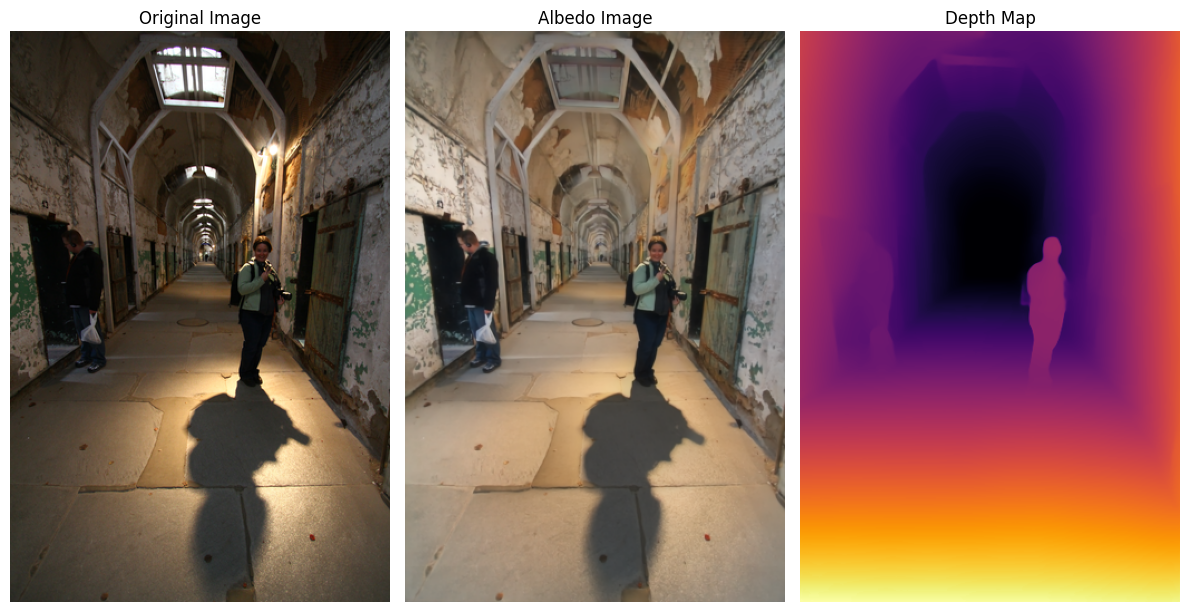

In [105]:
img_original = cv2.cvtColor(cv2.imread(f"before/{img_name}.png"), cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
img_albedo = cv2.cvtColor(cv2.imread(f"iiw_out_val/{img_name}.png"), cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(1, 3)

ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(img_original)
ax1.set_title("Original Image")
ax1.axis("off")

ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(img_albedo)
ax2.set_title("Albedo Image")
ax2.axis("off")

ax3 = fig.add_subplot(gs[0, 2])
ax3.imshow(depth_map_vis, cmap="inferno")
ax3.set_title("Depth Map")
ax3.axis("off")

plt.tight_layout()
plt.show()

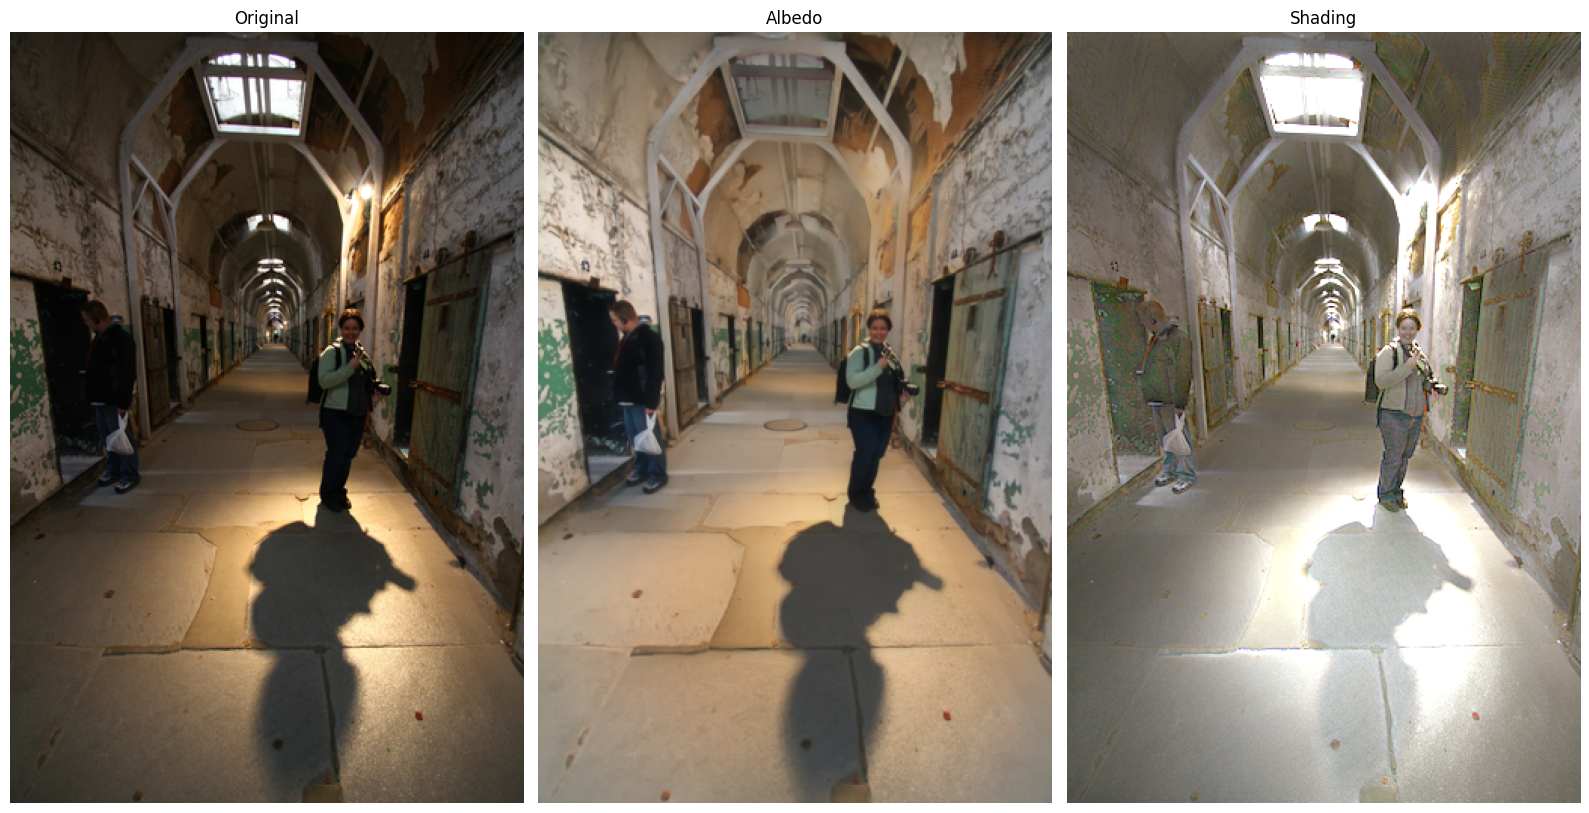

In [106]:
img_original = img_original
img_albedo = img_albedo
img_albedo = np.clip(img_albedo, 1e-4, 1.0)  # avoid division by 0

shading = img_original / img_albedo
shading = np.clip(shading, 0, 1)

plt.figure(figsize=(16, 12))
plt.subplot(1, 3, 1); plt.imshow(img_original); plt.title("Original"); plt.axis("off")
plt.subplot(1, 3, 2); plt.imshow(img_albedo); plt.title("Albedo"); plt.axis("off")
plt.subplot(1, 3, 3); plt.imshow(shading); plt.title("Shading"); plt.axis("off")
plt.tight_layout(); plt.show()

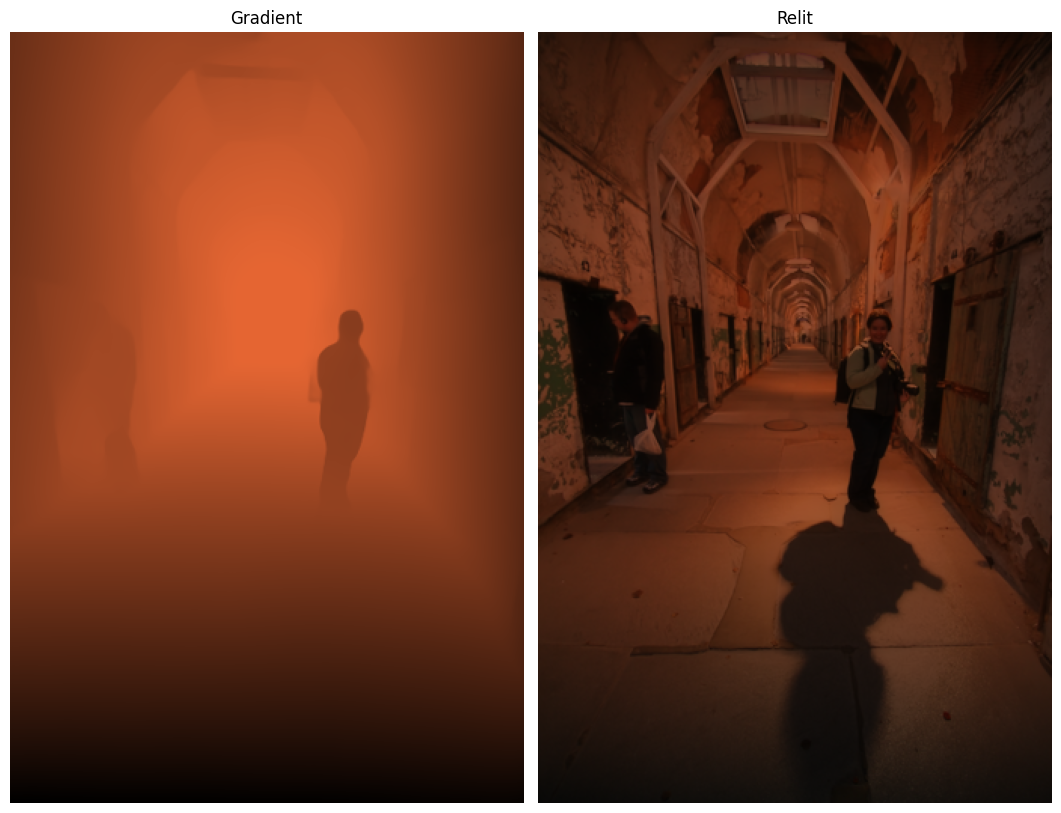

In [111]:
depth = depth_map.astype(np.float32)
depth_norm = (depth - depth.min()) / (depth.max() - depth.min() + 1e-8)
# depth_norm = depth_norm * 0

sunset_color = np.array([0.9, 0.4, 0.2])

# Generate a smooth, warm gradient based on depth
gradient_shading = (1 - depth_norm[..., None]) * sunset_color

# Option A: Replace original shading
alpha = 0.2
blended_shading = alpha * shading + (1 - alpha) * gradient_shading
blended_shading = np.clip(blended_shading, 0, 1)

# Step 3: Apply to albedo
relit_image = img_albedo * blended_shading
relit_image = np.clip(relit_image, 0, 1)

plt.figure(figsize=(16, 12))
plt.subplot(1, 3, 1); plt.imshow(gradient_shading); plt.title("Gradient"); plt.axis("off")
plt.subplot(1, 3, 2); plt.imshow(relit_image); plt.title("Relit"); plt.axis("off")
plt.tight_layout(); plt.show()

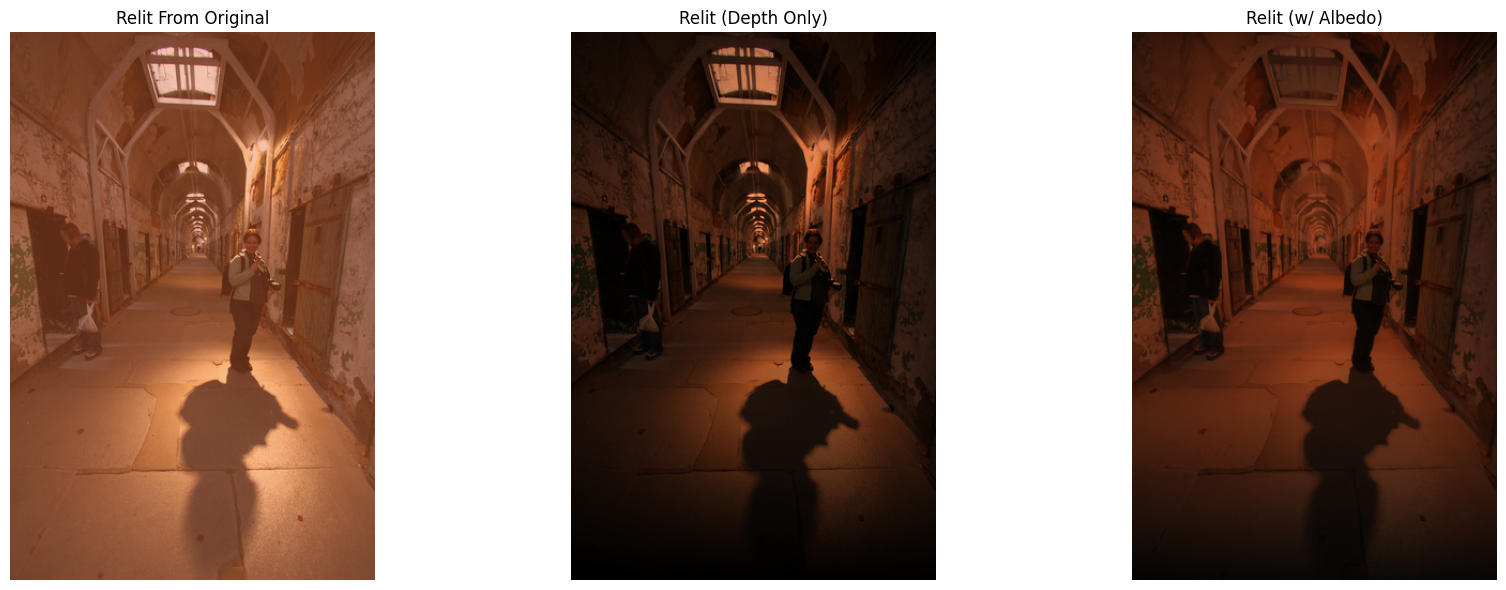

In [109]:
# Normalize depth
depth = depth_map.astype(np.float32)
depth_norm = (depth - depth.min()) / (depth.max() - depth.min() + 1e-8)

# Generate sunset gradient shading based on depth
depth_gradient = (1 - depth_norm[..., None]) * np.array([1.0, 0.6, 0.4])  # warm color tone

# Apply gradient directly to original image (no albedo)
relit_depth_only = img_original * depth_gradient
relit_depth_only = np.clip(relit_depth_only, 0, 1)

sunset_color = np.array([0.9, 0.4, 0.2])  # warm orange-red tone

# Get image size
height, width = img_original.shape[:2]

# Create a uniform gradient overlay (same color everywhere)
gradient_overlay = np.ones((height, width, 1)) * sunset_color  # shape: [H, W, 3]

# Blend with original image
alpha = 0.4  # blending strength
relit_image_original = (1 - alpha) * img_original + alpha * gradient_overlay
relit_image_original = np.clip(relit_image_original, 0, 1)

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1); plt.imshow(relit_image_original); plt.title("Relit From Original"); plt.axis("off")
plt.subplot(1, 3, 2); plt.imshow(relit_depth_only); plt.title("Relit (Depth Only)"); plt.axis("off")
plt.subplot(1, 3, 3); plt.imshow(relit_image); plt.title("Relit (w/ Albedo)"); plt.axis("off")
plt.tight_layout(); plt.show()

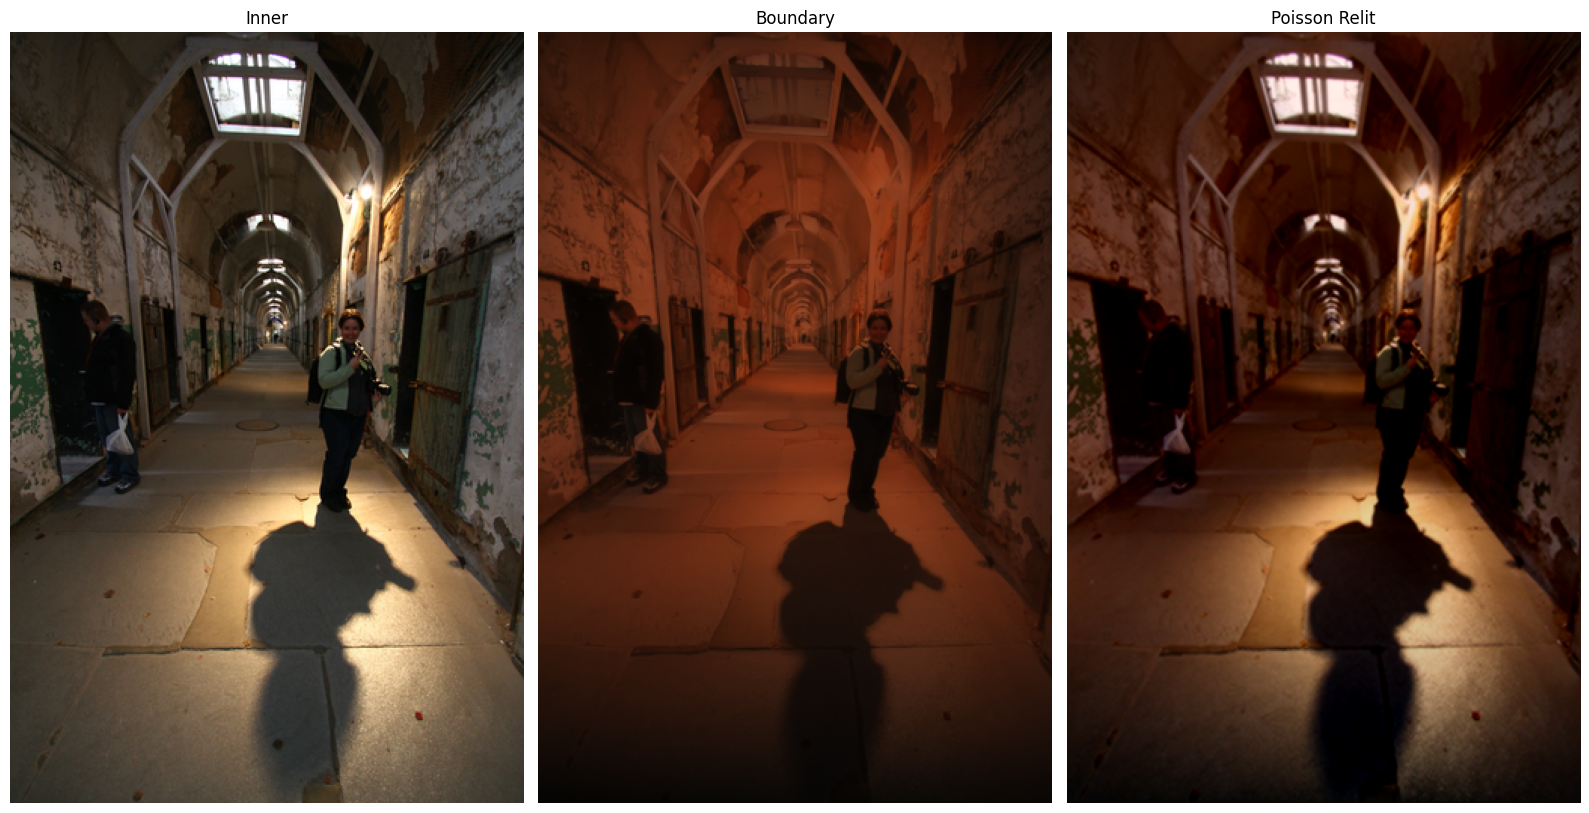

In [110]:
import numpy as np
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

def poisson_reconstruct(gx, gy, boundary_image):
    h, w, c = boundary_image.shape
    N = h * w

    # Laplacian matrix (sparse)
    A = lil_matrix((N, N))
    for y in range(h):
        for x in range(w):
            idx = x + y * w
            if 0 < x < w-1 and 0 < y < h-1:
                A[idx, idx] = -4
                A[idx, idx-1] = A[idx, idx+1] = 1
                A[idx, idx-w] = A[idx, idx+w] = 1
            else:
                A[idx, idx] = 1  # boundary

    result = np.zeros((h, w, c))
    for ch in range(c):
        # Compute divergence for this channel
        div = np.zeros((h, w))
        div[1:-1,1:-1] = (
            (gx[1:-1,2:,ch] - gx[1:-1,:-2,ch]) / 2 +
            (gy[2:,1:-1,ch] - gy[:-2,1:-1,ch]) / 2
        )

        b = np.zeros(N)
        for y in range(h):
            for x in range(w):
                idx = x + y * w
                if 0 < x < w-1 and 0 < y < h-1:
                    b[idx] = div[y, x]
                else:
                    b[idx] = boundary_image[y, x, ch]  # boundary

        x_sol = spsolve(A.tocsr(), b)
        result[..., ch] = x_sol.reshape((h, w))

    result = np.clip(result, 0, 1)
    return result

# Create your shading gradient
sunset_color = np.array([0.9, 0.4, 0.2])
gradient_overlay = np.ones_like(img_original) * sunset_color  # full sunset, no vertical grad

x1 = img_original
x2 = relit_image
# Get gradients
gx = np.gradient(x1, axis=1)
gy = np.gradient(x1, axis=0)

# Reconstruct using original as boundary
relit_poisson = poisson_reconstruct(gx, gy, x2)

# Show results
plt.figure(figsize=(16, 12))
plt.subplot(1, 3, 1); plt.imshow(x1); plt.title("Inner"); plt.axis("off")
plt.subplot(1, 3, 2); plt.imshow(x2); plt.title("Boundary"); plt.axis("off")
plt.subplot(1, 3, 3); plt.imshow(relit_poisson); plt.title("Poisson Relit"); plt.axis("off")
plt.tight_layout(); plt.show()